<a href="https://colab.research.google.com/github/bhelfer/DeepBees/blob/main/bees_conv_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Mount Directory

In [1]:
import os
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# 1. Import and Install Deps

In [2]:
import os
import datetime
import time
import math
import numpy as np
import random
import pandas as pd
import scipy as sp
import sys
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
import torchaudio
from torchaudio import transforms
from glob import glob
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
import torch.nn.functional as F
from torch.nn import init
from tqdm import tqdm

from IPython.display import Audio

# 2. Data Loading

## 2.1 Set up file paths

In [3]:
dsep = os.sep
root_dir = "Bees" #@param {type:"string"}
ds_name = "recordings" #@param {type:"string"}
ds_date = "202308_primary" #@param {type:"string"}
out_dir_name = "Output" #@param {type:"string"}
# Path to recordings
data_path = ("{}content{}drive{}MyDrive{}".format(dsep, dsep, dsep, dsep) +
             root_dir + dsep +
             ds_name + dsep +
             ds_date)

# Output path
out_dir = ("{}content{}drive{}MyDrive{}".format(dsep, dsep, dsep, dsep) +
             root_dir + dsep + out_dir_name)

#Testing on individual file
test_name = "20230814-123422_Period_recording_300_0_Zeev-Berkeley_Z1.wav" #@param {type:"string"}
test_file = ("{}content{}drive{}MyDrive{}".format(dsep, dsep, dsep, dsep) +
             root_dir + dsep +
             test_name)

# Temperature data
labels_name = "Z1_combined_readings_2023-08-29T17_12_09.188Z.csv" #@param {type:"string"}
labels_file = ("{}content{}drive{}MyDrive{}".format(dsep, dsep, dsep, dsep) +
             root_dir + dsep +
             labels_name)

### 2.1.1 Check files are found and in path

In [4]:
print("Test File exists:", os.path.isfile(test_file))
print("File name: ", test_file)
print(len(os.listdir(data_path)), "files found in directory")
print("Labels File exists:", os.path.isfile(labels_file))
print("File name: ", labels_file)

Test File exists: True
File name:  /content/drive/MyDrive/Bees/20230814-123422_Period_recording_300_0_Zeev-Berkeley_Z1.wav
2845 files found in directory
Labels File exists: True
File name:  /content/drive/MyDrive/Bees/Z1_combined_readings_2023-08-29T17_12_09.188Z.csv


In [ ]:
file_paths = [os.path.join(data_path, file_name) for file_name in os.listdir(data_path)]
file_sizes = [os.path.getsize(file_path) for file_path in file_paths]

size_df = pd.DataFrame({'file_path': file_paths, 'file_size': file_sizes}).sort_values('file_size', ascending = False)


In [ ]:
size_df

,file_path,file_size
374,/content/drive/MyDrive/Bees/recordings/202308_...,330046008
370,/content/drive/MyDrive/Bees/recordings/202308_...,330046008
380,/content/drive/MyDrive/Bees/recordings/202308_...,330046008
379,/content/drive/MyDrive/Bees/recordings/202308_...,330046008
376,/content/drive/MyDrive/Bees/recordings/202308_...,330046008
...,...,...
2214,/content/drive/MyDrive/Bees/recordings/202308_...,0
2215,/content/drive/MyDrive/Bees/recordings/202308_...,0
2216,/content/drive/MyDrive/Bees/recordings/202308_...,0
2220,/content/drive/MyDrive/Bees/recordings/202308_...,0


In [ ]:
print(test_file.split("/")[-1].split("_Period")[0])
date_str = test_file.split("/")[-1].split("_Period")[0]
d = datetime.datetime.strptime(date_str, "%Y%m%d-%H%M%S")
unixtime = time.mktime(d.timetuple())
print("unix time:", unixtime)

20230814-123422
unix time: 1692016462.0


## 2.2 Read Audio

In [ ]:
data, sr = torchaudio.load(test_file, normalize=False)

In [ ]:
torchaudio.load?

In [ ]:
tmp = data.numpy()

In [ ]:
tmp.shape

(2, 57642468)

In [ ]:
data[0, :9]

tensor([-0.0075,  0.0018, -0.0023,  0.0008, -0.0043, -0.0013, -0.0021, -0.0027,
        -0.0003])

In [ ]:
print(f" - Max:     {data.max().item():6.3f}")
print(f" - Min:     {data.min().item():6.3f}")
print(f" - Mean:    {data.mean().item():6.3f}")
print(f" - Std Dev: {data.std().item():6.3f}")

 - Max:      1.000
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.007


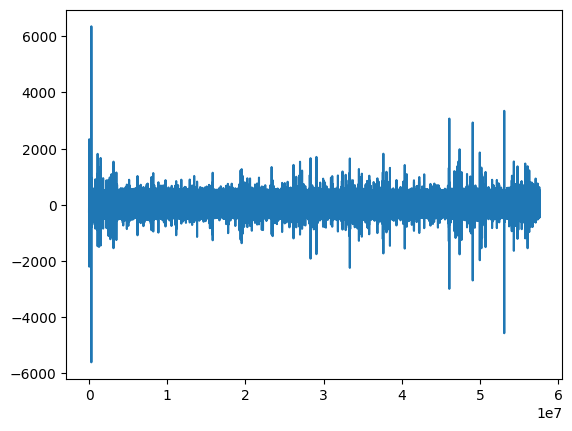

In [ ]:
plt.plot(tmp[1, :])
plt.show()

## 2.3 Audio Preprocessing Data Class




In [4]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file, frame_offset=0, num_frames=-1):
        sig, sr = torchaudio.load(audio_file, frame_offset=frame_offset,
                                  num_frames=num_frames)
        return (sig, sr)

    # ----------------------------
    # Split up filename to get date and return as unix time
    # ----------------------------
    @staticmethod
    def get_utime(audio_file):
        #Decode filename for time to index with labels
        date_str = audio_file.split("/")[-1].split("_")[0]
        d = datetime.datetime.strptime(date_str, "%Y%m%d-%H%M%S")
        unixtime = time.mktime(d.timetuple())
        return unixtime

   	# ----------------------------
    # Handle Mono or Stereo audio
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the Second channel
            resig = sig[1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])

        return ((resig, sr))

    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_s' in seconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_s):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr * max_s

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

### 2.3.1 Test Audio Class

In [ ]:
# Load file
aud = AudioUtil.open(test_file)


In [ ]:
sig, sr = aud
print("Sampling Rate: ", sr)
print("Number of Channels: ", sig.shape[0])

Sampling Rate:  192000
Number of Channels:  2


In [ ]:
print("File is ", sig.shape[1]/sr, "seconds long")

File is  300.2211875 seconds long


In [ ]:
new_sr = 44100
reaud = AudioUtil.resample(aud, new_sr)

In [ ]:
reaud

(tensor([[-0.0016, -0.0018, -0.0014,  ..., -0.0018, -0.0025, -0.0025],
         [-0.0013, -0.0001, -0.0006,  ..., -0.0021, -0.0024, -0.0025]]),
 44100)

In [ ]:
reaud[0].shape

torch.Size([2, 13239755])

In [ ]:
# Let's take a 5 second sample of the audio file
samp_time = 5 * new_sr
reaud_sig = reaud[0][:, 20000:20000+samp_time]

In [ ]:
reaud_sig.shape

torch.Size([2, 220500])

In [ ]:
shift_aud = AudioUtil.time_shift((reaud_sig, new_sr), 0.4)

In [ ]:
shift_aud[0].shape

torch.Size([2, 220500])

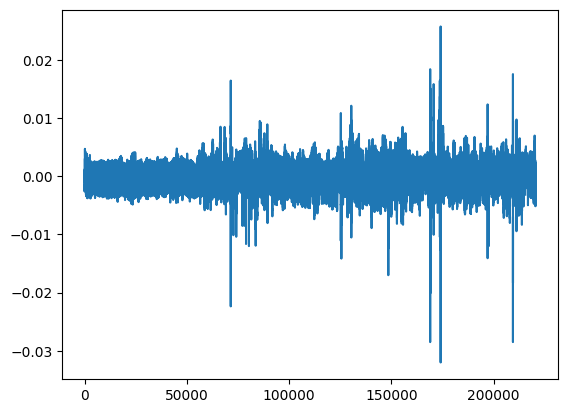

In [ ]:
plt.plot(range(shift_aud[0].shape[1]), shift_aud[0][1, :])
plt.show()

In [ ]:
# Make a spectrogram
sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)

In [ ]:
sgram.shape

torch.Size([2, 64, 431])

In [ ]:
sgram.dtype

torch.float32

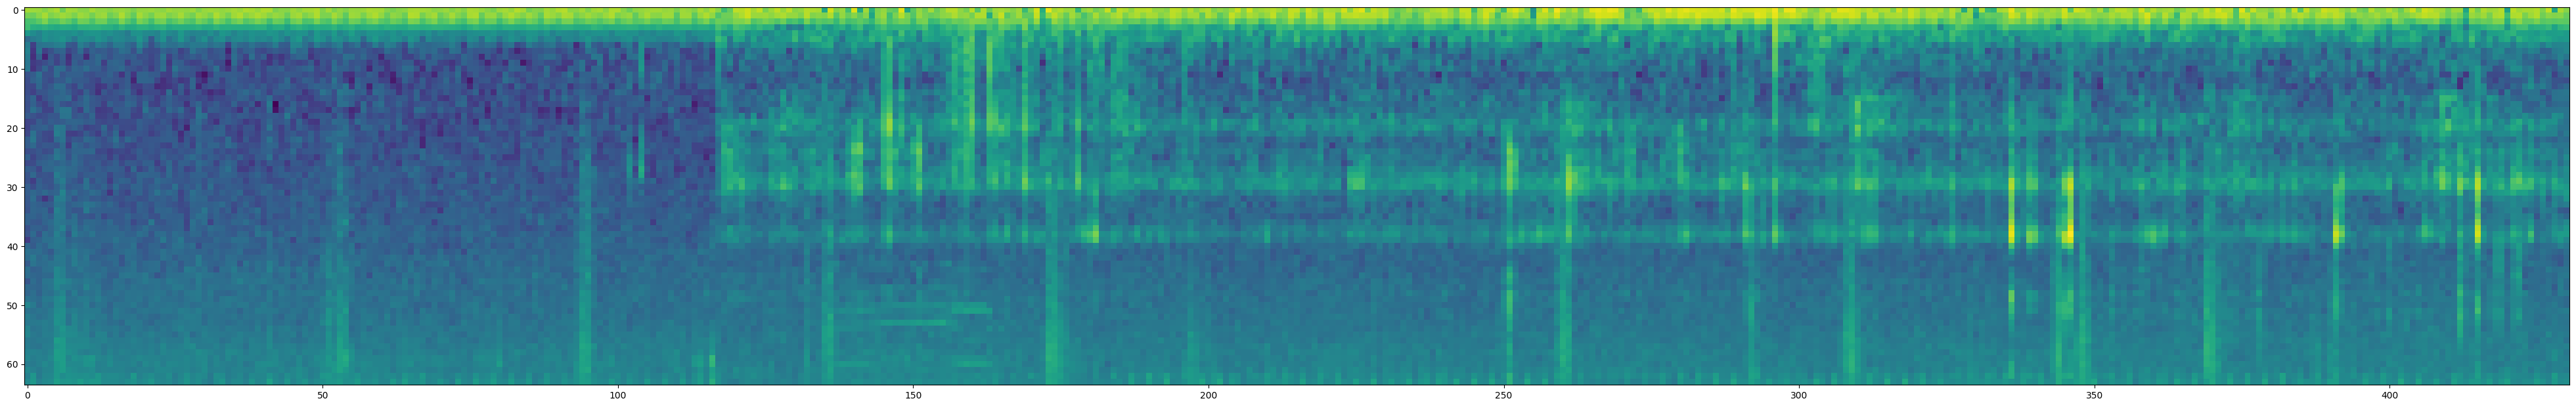

In [ ]:
plt.figure(figsize=(50, 30))
plt.imshow(sgram[1, : , :])
plt.show()

In [ ]:
aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

In [ ]:
aug_sgram.dtype

torch.float32

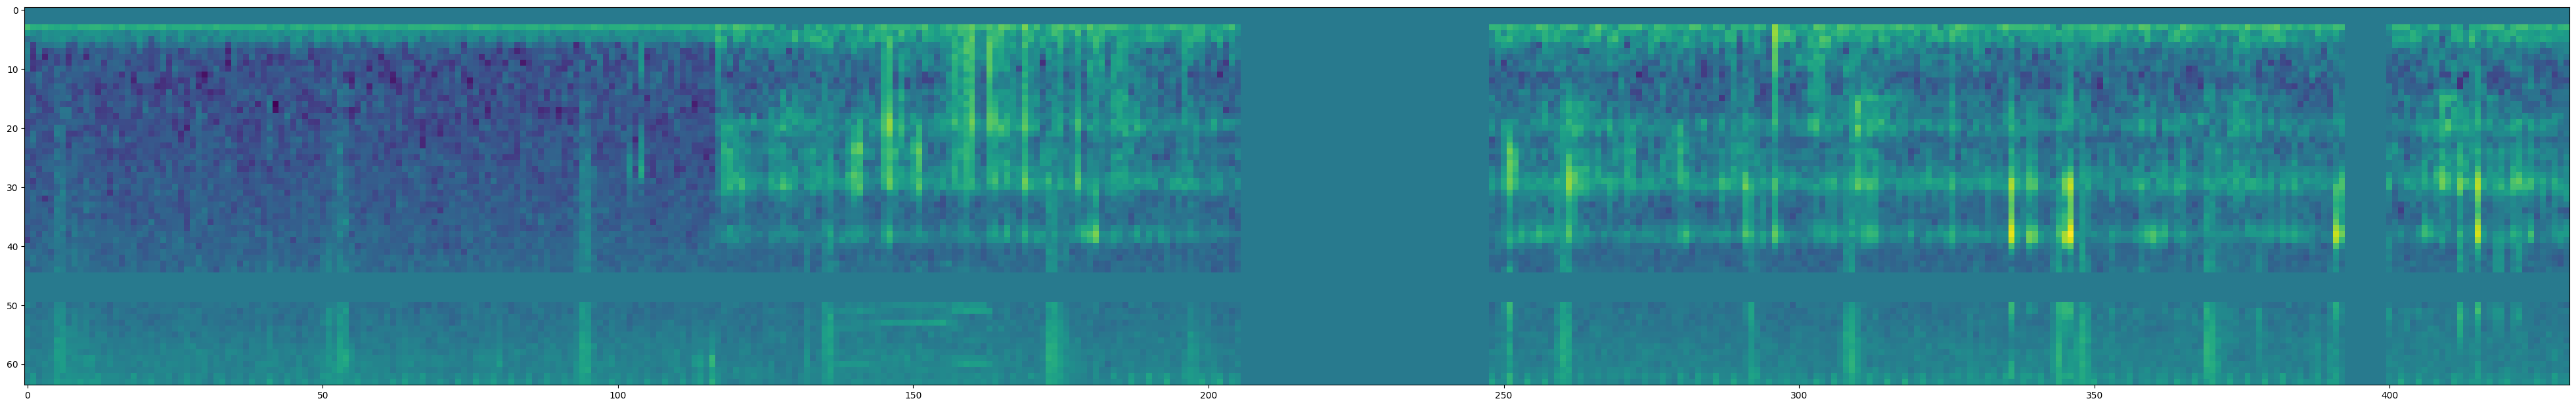

In [ ]:
plt.figure(figsize=(50, 30))
plt.imshow(aug_sgram[1, : , :])
plt.show()

In [ ]:
print(sys.getsizeof(aud))
print(sys.getsizeof(aug_sgram))

56
72


## 2.4 Find all the small files

In [ ]:
data_path

'/content/drive/MyDrive/Bees/recordings/202308_primary'

In [ ]:
file_list = glob(data_path + dsep + '*Period*.flac')

In [ ]:
len(file_list)

2449

In [ ]:
d.shape[1] / sr

NameError: ignored

In [ ]:
file_list_sh = file_list[1875:]

In [ ]:
len(file_list_sh)

In [ ]:
file_list[1290]

In [ ]:
pr_file = '/content/drive/MyDrive/Bees/recordings/202308_primary/20230807-191949_Period_recording_300_0_Zeev-Berkeley_Z1.flac'

In [ ]:
file_list.index(pr_file)

In [ ]:
w_short = '/content/drive/MyDrive/Bees/short_files_c3.csv'
w_chan = '/content/drive/MyDrive/Bees/chan_files_c3.csv'

f_short = open(w_short, 'w')
f_chan = open(w_chan, 'w')



idx = 0
for f in file_list_sh:
    # print("processing: ", f)
    data, sr = AudioUtil.open(f)
    if data.shape[0] != 2:
        f_chan.write(f + '\n')
    if (data.shape[1] / sr) < 270:
        f_short.write(f + '\n')
    if idx % 20 == 0:
        print("Finished ", idx)
    idx += 1
f_short.close()
f_chan.close()


# 3.0 Assemble Dataset

## 3.1 Interpolate the temps

In [5]:
labels_file

'/content/drive/MyDrive/Bees/Z1_combined_readings_2023-08-29T17_12_09.188Z.csv'

In [6]:
labels = pd.read_csv(labels_file)

In [7]:
labels.columns

Index(['App', 'Device', 'Hive_Position', 'Record_Type', 'UTC_TimeStamp',
       'Local_TimeStamp', 'Unix_Time', 'Sample', 'Metric', 'Battery',
       'Temperature', 'Humidity', 'Scaled_Weight', 'Weight_Scale_Factor',
       'Weight', 'w1', 'w3', 'w2', 'w4', 'Radar', 'Audio'],
      dtype='object')

In [8]:
# Hive pos can be: 'Inner Cover', 'Lower Brood', 'Scale Under Hive',
#                  'Upper Brood', 'Scale Under Hive (Back)'
hive_pos = "Scale Under Hive (Back)" #@param ['Inner Cover', 'Lower Brood', 'Scale Under Hive','Upper Brood', 'Scale Under Hive (Back)']
labels_hive = labels.loc[labels.Hive_Position == hive_pos,
                         ['UTC_TimeStamp', 'Unix_Time', 'Temperature']]

In [ ]:
# Checking that unix time is in ascending order
labels_hive.Unix_Time.is_monotonic_increasing

True

<Axes: xlabel='Unix_Time'>

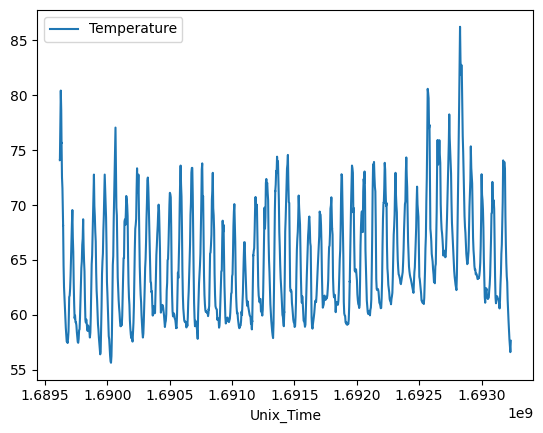

In [ ]:
labels_hive.plot('Unix_Time', 'Temperature')

In [9]:
# Interpolate temperature
ti = labels_hive.Unix_Time.values
te = labels_hive.Temperature.values
cs = sp.interpolate.CubicSpline(ti, te)

In [10]:
cs_val = cs(ti)

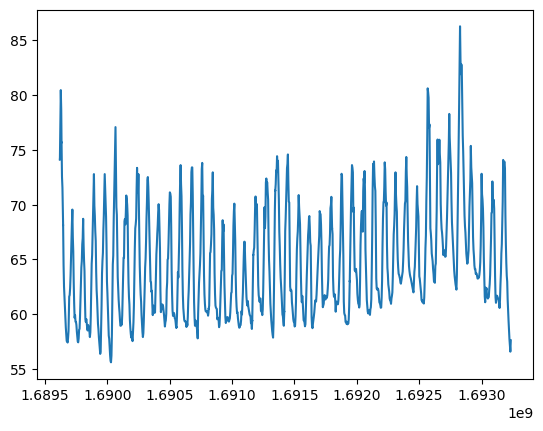

In [ ]:
plt.plot(ti, cs_val)

In [ ]:
len(ti)

1054

In [11]:
# Set step for interpolation
t_step = 100 # @param {type:"integer"}

In [ ]:
ti_int = range(ti[0], ti[-1], t_step)

In [ ]:
len(ti_int)

36134

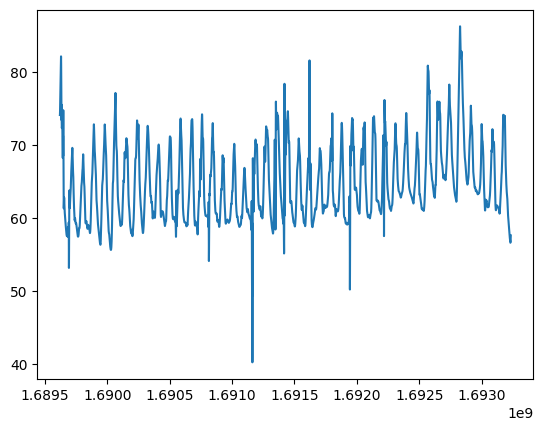

In [ ]:
plt.plot(ti_int, cs(ti_int))

In [13]:
# Find values less than the min and and set to min
cs_val = cs(ti_int)
below_min = np.where(cs_val < min(te))[0]
below_min

NameError: ignored

In [ ]:
cs_val[below_min] = min(te)

In [ ]:
# Find values greater than the max and and set to max
above_max = np.where(cs_val > max(te))[0]
above_max

array([32065])

In [ ]:
cs_val[above_max] = max(te)

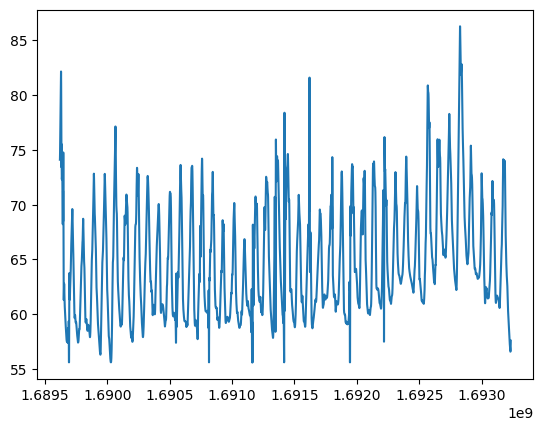

In [ ]:
plt.plot(ti_int, cs_val)

## 3.2 Make a dataframe with file paths and output temp

In [12]:
data_path

'/content/drive/MyDrive/Bees/recordings/202308_primary'

In [13]:
file_list = glob(data_path + dsep + '*Period*.flac')

In [14]:
len(file_list)

2449

In [ ]:
f = file_list[0]
print(f)
print(f.split(dsep)[-1])
print(AudioUtil.get_utime(f.split(dsep)[-1]))
print(cs(AudioUtil.get_utime(f.split(dsep)[-1])))

/content/drive/MyDrive/Bees/recordings/202308_primary/20230824-055341_Period_recording_300_0_Zeev-Berkeley_Z1.flac
20230824-055341_Period_recording_300_0_Zeev-Berkeley_Z1.flac
1692856421.0
72.58639962475378


In [15]:
# Get a temp for each file
temp_list = []
for f in file_list:
    fname = f.split(dsep)[-1]
    ut = AudioUtil.get_utime(fname)
    temp_list.append(cs(ut))



In [16]:
under_min = np.where(temp_list < min(te))[0]

In [17]:
min(te)

55.63

In [18]:
temp_arr = np.array(temp_list)
temp_arr[under_min]

array([55.36211856, 55.14078821, 55.21094898])

In [19]:
temp_arr[under_min] = min(te)

In [20]:
over_max = np.where(temp_list > max(te))
temp_arr[over_max] = max(te)

In [21]:
# Create dataframe with paths and temps
df = pd.DataFrame({'Path': file_list, 'Temp': temp_arr})
df.head()

,Path,Temp
0,/content/drive/MyDrive/Bees/recordings/202308_...,72.586400
1,/content/drive/MyDrive/Bees/recordings/202308_...,72.403720
2,/content/drive/MyDrive/Bees/recordings/202308_...,72.224975
3,/content/drive/MyDrive/Bees/recordings/202308_...,72.049262
4,/content/drive/MyDrive/Bees/recordings/202308_...,71.875718


In [ ]:
idx, row = next(df.iterrows())

In [ ]:
print(idx)
row

0


Path    /content/drive/MyDrive/Bees/recordings/202308_...
Temp                                            69.084305
Name: 0, dtype: object

In [ ]:
df.Temp.min()

55.63

In [ ]:
df.Temp.max()

86.22453225796271

## 3.3 Data loader class

In [22]:
2# ----------------------------
# Params for Dataset
# ----------------------------
DEFAULT_SR = 192000
duration = 5 #@param {type:'integer'}
num_windows = 5 #@param {type:'integer'}
sr = 44100 #@param {type:'integer'}
channel = 2 # @param {type:"integer"}
init_offset = 100 # @param {type:"integer"}
shift_pct = 0.4 #@param {type:'number'}


In [33]:
# ----------------------------
# Bee Dataset
# ----------------------------
class BeeDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = duration
        self.num_windows = num_windows
        self.sr = sr
        self.init_offset = init_offset
        self.channel = channel
        self.shift_pct = shift_pct

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df) * self.num_windows

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Find file from floor div based on number of windows
        file_idx = idx // self.num_windows
        fname = self.df.loc[file_idx, 'Path']
        # print(fname)
        temp = self.df.loc[file_idx, 'Temp']

        # Determine which window we're processing in the file
        curr_window = idx % self.num_windows
        # ipdb.set_trace(context=6)

        # Read that window from the file
        # Try to open file 3 times since drive likes to fail
        num_tries = 0
        f_offset=curr_window * DEFAULT_SR * self.duration + self.init_offset
        n_frames = DEFAULT_SR * self.duration
        while num_tries < 3:
            try:
                aud = AudioUtil.open(fname, frame_offset=f_offset,
                                     num_frames=n_frames)
                break
            except:
                num_tries += 1
                time.sleep(0.05)


        # ipdb.set_trace(context=6)
        if (aud[0].shape[0] != 2):
            raise Exception("Channels greater than Expected")
        # Reducing sampling rate
        reaud = AudioUtil.resample(aud, self.sr)

        #shift audio
        shift_aud = AudioUtil.time_shift(reaud, self.shift_pct)

        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64,
                                       n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1,
                                              n_freq_masks=2, n_time_masks=2)
        if aug_sgram.shape[0] != 2:
            raise Exception("Channels greater than expected")

        return aug_sgram, torch.tensor(temp, dtype=torch.float32)

### 3.3.1 Testing Loader

In [ ]:
# Let's test getting a single item
idx = 37
# Find file from floor div based on number of windows
file_idx = idx // num_windows
fname = df.loc[file_idx, 'Path']
temp = df.loc[file_idx, 'Temp']

print("filename: ", fname)
print("Temp: ", temp)


filename:  /content/drive/MyDrive/Bees/recordings/202308_primary/20230824-080054_Period_recording_300_0_Zeev-Berkeley_Z1.flac
Temp:  68.74750184338282


In [ ]:
# Determine which window we're processing in the file
curr_window = idx % num_windows

# Read that window from the file
aud = AudioUtil.open(fname,
                     frame_offset=curr_window * DEFAULT_SR * duration + init_offset,
                     num_frames=DEFAULT_SR * duration)


In [ ]:
# Reducing sampling rate
reaud = AudioUtil.resample(aud, sr)

#shift audio
shift_aud = AudioUtil.time_shift(reaud, shift_pct)

sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64,
                                n_fft=1024, hop_len=None)
aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1,
                                        n_freq_masks=2, n_time_masks=2)

In [ ]:
aug_sgram.shape[0]

2

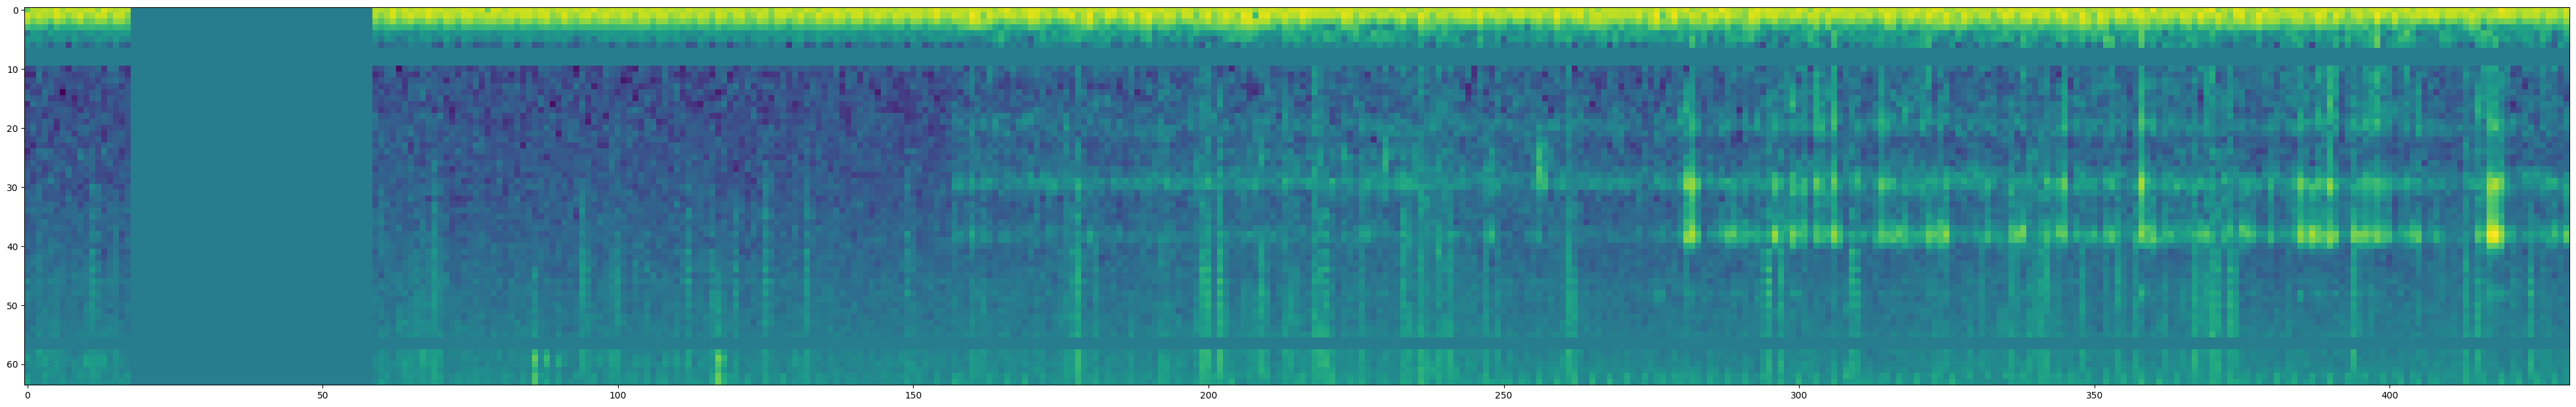

In [ ]:
plt.figure(figsize=(50, 30))
plt.imshow(aug_sgram[1, : , :])
plt.show()

In [ ]:
%timeit sig, sr = torchaudio.load(fname, frame_offset=192000*50, num_frames=192000*5)

574 ms ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
bee_ds = BeeDS(df)

In [ ]:
d, t = bee_ds.__getitem__(22)

In [ ]:
print(t)

72.22497535638806


In [ ]:
torch.tensor(t, dtype=torch.float32).dtype

torch.float32

In [ ]:
d.dtype

torch.float32

## 3.4 Batch the data

In [24]:
bee_ds = BeeDS(df)

# Start with 80/20 train/validation split
num_pts = len(bee_ds)
print("There are a total of: ", num_pts, "data points")

num_train = round(num_pts * 0.8)
num_val = num_pts - num_train
train_ds, val_ds = random_split(bee_ds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

There are a total of:  12245 data points


### 3.4.1 Testing batch loader

In [ ]:
for i in range(len(bee_ds)):
    print(i)
    data, temp = bee_ds.__getitem__(i)
    if data.shape[0] != 2:
        raise Exception("greater than 2")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

RuntimeError: ignored

> /usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py(1547)_apply_sinc_resample_kernel()
   1545     # pack batch
   1546     shape = waveform.size()
-> 1547     waveform = waveform.view(-1, shape[-1])
   1548 
   1549     num_wavs, length = waveform.shape

ipdb> q


In [ ]:
1886 // 10

188

In [ ]:
1886 % 10

6

In [ ]:
bee_ds.__getitem__(1886)

RuntimeError: ignored

> /usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py(1547)_apply_sinc_resample_kernel()
   1545     # pack batch
   1546     shape = waveform.size()
-> 1547     waveform = waveform.view(-1, shape[-1])
   1548 
   1549     num_wavs, length = waveform.shape

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [ ]:
fname = df.loc[188].Path
print(fname)

/content/drive/MyDrive/Bees/recordings/202308_primary/20230824-233746_Period_recording_300_0_Zeev-Berkeley_Z1.flac


In [ ]:
aud = AudioUtil.open(fname)

In [ ]:
aud[0].shape

torch.Size([2, 4802856])

In [ ]:
aud = AudioUtil.open(fname,
                     frame_offset=6 * DEFAULT_SR * duration + init_offset,
                     num_frames=DEFAULT_SR * duration)

In [ ]:
aud[0].shape

torch.Size([2, 0])

In [ ]:
reaud = AudioUtil.resample(aud, sr)

#shift audio
shift_aud = AudioUtil.time_shift(reaud, shift_pct)

sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64,
                                n_fft=1024, hop_len=None)
aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1,
                                        n_freq_masks=2, n_time_masks=2)

In [ ]:
aug_sgram.shape

torch.Size([2, 64, 431])

In [ ]:
for i, data in enumerate(train_dl):
    input, temps = data[0], data[1]
    print(input.shape)

RuntimeError: ignored

> /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py(162)collate_tensor_fn()
    160         storage = elem._typed_storage()._new_shared(numel, device=elem.device)
    161         out = elem.new(storage).resize_(len(batch), *list(elem.size()))
--> 162     return torch.stack(batch, 0, out=out)
    163 
    164 

ipdb> q


In [ ]:
en = enumerate(train_dl)

In [ ]:
i, data = next(en)

# 4. Deep Conv Net Architecture

## 4.1 Model Architecture

In [34]:
# ----------------------------
# Audio Prediction Model
# ----------------------------
class AudioPredictor (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=1)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x



In [36]:
# Create the model and put it on the GPU if available
myModel = AudioPredictor()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [37]:
torch.cuda.is_available()

False

## 4.2 Set up training

In [ ]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [29]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')
    ckpt_name = out_dir + dsep + 'checkpoint_'

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_mse = 0
        loop = tqdm(train_dl)

        # Repeat for each batch in the training set
        # for i, data in enumerate(train_dl):
        for i, data in enumerate(loop):
            # Get the input features and target temps, and put them on the GPU
            inputs, temps = data[0].to(device), data[1].to(device)
            # print(inputs.shape)

            # ipdb.set_trace(context=6)
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = torch.flatten(model(inputs))

            loss = criterion(outputs, temps)
            loss.backward()
            optimizer.step()
            scheduler.step()

            mse = criterion(outputs, temps)
            running_mse += mse

            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

            #if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_mse = running_mse / num_batches
        print(f'Epoch: {epoch}, MSE: {avg_mse:.2f}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, ckpt_name + str(epoch) + '.pt')

    print('Finished Training')



In [30]:
# Set epochs and train model
num_epochs=3
training(myModel, train_dl, num_epochs)

Epoch [0/3]:  95%|█████████▍| 581/613 [1:51:41<06:09, 11.53s/it, loss=2.05e+3]


RuntimeError: ignored

In [ ]:
os.path.isfile("/content/drive/MyDrive/Bees/recordings/202308_primary/20230824-113941_Period_recording_300_0_Zeev-Berkeley_Z1.flac")

True

In [32]:
os.path.isfile("/content/drive/MyDrive/Bees/recordings/202308_primary/20230820-222039_Period_recording_300_0_Zeev-Berkeley_Z1.flac")

True

# 5. Predictions

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
    pred_temps = []
    true_temps = []
    criterion = nn.MSELoss()

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target temps, and put them on the GPU
            inputs, temps = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)
            pred_temps.extend(outputs)
            true_temps.extend(temps)

    acc = criterion(pred_temps, true_temps)
    print(f'Accuracy: {acc:.2f}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)